In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

## Data quality check / cleaning / preparation 

In [3]:
# reading in the data
nba_2017 = pd.read_csv('https://raw.githubusercontent.com/Dmjohnson4/Stat-303-3-Datasets/main/NBA%20Players%20Stats%20201718.csv',
                            encoding='latin-1')
nba_2018 = pd.read_csv('https://raw.githubusercontent.com/Dmjohnson4/Stat-303-3-Datasets/main/NBA%20Players%20Stats%20201819.csv',
                            encoding = 'latin-1')

### Data cleaning
*By Davis Johnson*

In [4]:
#Train Dataset#

## getting rid of '//' characters in player names
nba_2017['Player'] = nba_2017['Player'].str.split('\\').str[0]

## If players played for more than one team, we want to only keep the row that has their total stats for the year
## applying boolean mask to get of rid of extra rows belonging to players and only keeping their 'TOT' rows
duplicated_players = nba_2017['Player'].duplicated(keep=False)
mask = duplicated_players & (nba_2017['Tm'] == 'TOT')
filtered_df = nba_2017[mask]

## creating seperate subset of players that don't have more than one row
single_team_df = nba_2017[~duplicated_players]

## combining previously created subset with players that played for more than one team and now only have one row assigned to them
nba_2017_2018 = pd.concat([filtered_df, single_team_df])
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

## filling all N/A values with 0, since we are assuming players have no stats for these data points
nba_2017_2018.fillna(0, inplace=True)


In [5]:
## repeating the process for test dataset
nba_2018['Player'] = nba_2018['Player'].str.split('\\').str[0]
duplicated_players = nba_2018['Player'].duplicated(keep=False)
mask = duplicated_players & (nba_2018['Tm'] == 'TOT')
filtered_df = nba_2018[mask]
single_team_df = nba_2018[~duplicated_players]
nba_2018_2019 = pd.concat([filtered_df, single_team_df])
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)
nba_2018_2019.fillna(0, inplace=True)


### Data preparation
*By Davis Johnson*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We want to predict All-Star appearances. Thus, we manually created a response column using binary classification. A `1` in the column signifies that the player was an All-Star in the following year.

2. We also performed some basic data preparation techniques (dropping non-relevant predictors, removing players from the analysis who appeared in a limited number of games)

In [6]:
## Train dataset

## dropping predictors that won't factor into our analysis, we our focusing on stats
nba_2017_2018 = nba_2017_2018.drop(columns=['Rk','Tm', 'Pos'], axis=1)

## removing players who played less than 20 games
nba_2017_2018 = nba_2017_2018[nba_2017_2018['G'] >= 20]
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

## converting stats into percentage form
percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2017_2018[col] = nba_2017_2018[col] * 100

## creating response variable
## manually creating list of the following year's NBA All-Stars
all_star_list = ['Kemba Walker', 'Kyrie Irving', 'Kawhi Leonard', 'Giannis Antetokounmpo', 
                'Joel Embiid', 'Kyle Lowry', 'Victor Oladipo', 'Khris Middleton', 'Bradley Beal',
                'Ben Simmons', 'Blake Griffin', 'Nikola Vučević', "D'Angelo Russell",
                'Stephen Curry', 'James Harden', 'Kevin Durant', 'Paul George', 'LeBron James',
                'Russell Westbrook', 'Damian Lillard', 'Klay Thompson', 'Anthony Davis', 
                'LaMarcus Aldridge', 'DeMarcus Cousins', 'Nikola Jokić', 'Karl-Anthony Towns']

## assigning a 1 to rows in a new column if the player name is in the list above
nba_2017_2018['AS_NY'] = nba_2017_2018['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [7]:
## repeating process for test dataset

nba_2018_2019 = nba_2018_2019.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2018_2019 = nba_2018_2019[nba_2018_2019['G'] >= 20]
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2018_2019[col] = nba_2018_2019[col] * 100

all_star_list = ['Kemba Walker', 'Trae Young', 'Giannis Antetokounmpo', 'Pascal Siakam', 'Joel Embiid',
                'Kyle Lowry', 'Ben Simmons', 'Jimmy Butler', 'Khris Middleton', 'Bam Adebayo', 
                'Jayson Tatum', 'Domantas Sabonis', 'James Harden', 'Luka Dončić', 'LeBron James',
                'Kawhi Leonard', 'Anthony Davis', 'Chris Paul', 'Russell Westbrook', 'Damian Lillard', 
                'Donovan Mitchell', 'Brandon Ingram', 'Nikola Jokić', 'Rudy Gobert', 'Devin Booker']
nba_2018_2019['AS_NY'] = nba_2018_2019['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [8]:
X_train = nba_2017_2018.drop(['Player', 'AS_NY'], axis=1) 
y_train = nba_2017_2018['AS_NY']  

X_test = nba_2018_2019.drop(['Player', 'AS_NY'], axis=1)  
y_test = nba_2018_2019['AS_NY']  

### Distribution of response
*By Davis Johnson*

Text(0.5, 1.0, "Number of 0's and 1's")

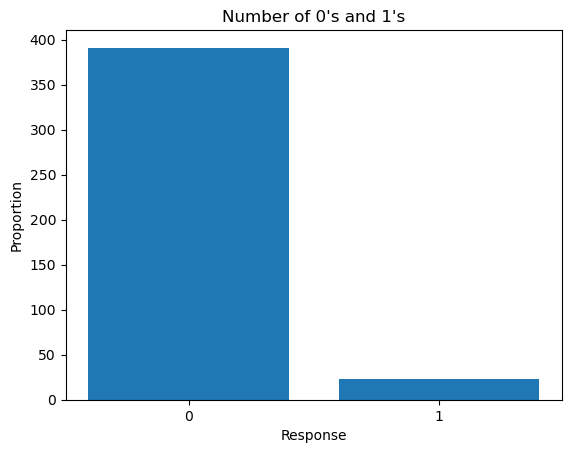

In [ ]:
## bar plot for distribution of response for train data
proportions = nba_2017_2018['AS_NY'].value_counts()
plt.bar(proportions.index.astype(str), proportions.values)
plt.xlabel('Response')
plt.ylabel('Proportion')
plt.title('Number of 0\'s and 1\'s')

Text(0.5, 1.0, "Number of 0's and 1's")

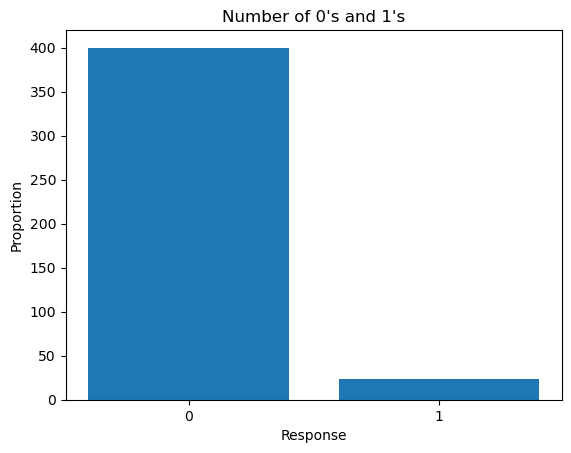

In [ ]:
## bar plot for distribution of response for test data
proportions = nba_2018_2019['AS_NY'].value_counts()
plt.bar(proportions.index.astype(str), proportions.values)
plt.xlabel('Response')
plt.ylabel('Proportion')
plt.title('Number of 0\'s and 1\'s')

For both datasets, we see very skewed class distributions. This makes sense, as there are over 400 NBA players in a given year and only about 25 are voted as an All-Star each year. We do keep this in mind during model development by using StratifiedKFold.

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Correlation Table (Andy)

<Axes: >

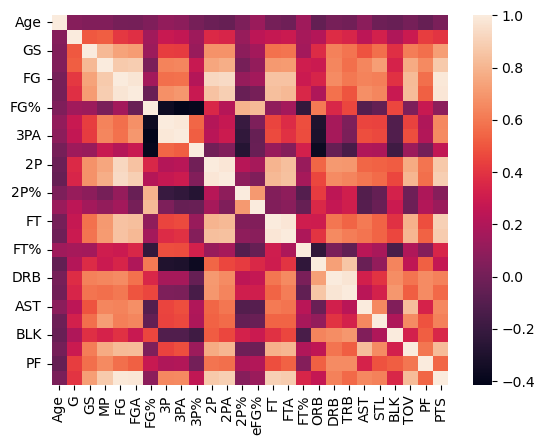

In [ ]:
# developing heatmap to analyze correlations
x_train_eda = nba_2017_2018.iloc[:, 1:-1]
sns.heatmap(x_train_eda.corr())

### Variance Inflation Factor (Andy)

In [ ]:
# Analyzing Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# analyze VIF for training data (2017-2018)
x_train_vif = nba_2017_2018.iloc[:, 1:-1]
X = add_constant(x_train_vif)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

# delete columns with high VIF values 
test_vif = vif_data.sort_values(by = 'VIF', ascending = False) 
test_vif

,feature,VIF
6,FGA,9278.338644
26,PTS,6855.495654
12,2PA,5214.888899
5,FG,4760.500282
20,TRB,2455.633794
9,3PA,2136.962689
11,2P,1669.580429
19,DRB,1382.304451
8,3P,568.795838
15,FT,386.671118


## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Lasso, Ridge & Catboost
*By Sylvia Sherwood*

### Random Forest
*By Izzy Podolsky*

In [9]:
#Hyperparameter tuning
param_grid = {
    'max_features' : (list(range(1, 19, 2))),
    'n_estimators' : [250, 500, 750]
}

model = RandomForestClassifier(random_state = 1, oob_score = True, verbose = False, n_jobs=-1)

cv = StratifiedKFold(n_splits = 5,shuffle = True, random_state = 1)
rfcv = GridSearchCV(estimator = model, 
                           param_grid = param_grid, 
                           scoring = ['roc_auc','accuracy'],
                           refit = 'roc_auc',
                           cv = cv,
                          n_jobs = -1,
                          verbose = 1)

result = rfcv.fit(X_train, y_train)

print("Best Accuracy Score: %f" % (result.cv_results_['mean_test_accuracy'][result.best_index_]))
print("Best ROC-AUC Score: %f" % (result.cv_results_['mean_test_roc_auc'][result.best_index_]))
print("Best Hyperparameters: ", result.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Accuracy Score: 0.968616
Best ROC-AUC Score: 0.993077
Best Hyperparameters:  {'max_features': 13, 'n_estimators': 250}


In [10]:
#Feature importances
pd.concat([pd.Series(result.best_estimator_.feature_importances_), pd.Series(X_train.columns)], axis=1).sort_values(by = 0,ascending = False)

,0,1
25,0.274295,PTS
4,0.177460,FG
14,0.068462,FT
5,0.068247,FGA
13,0.059364,eFG%
23,0.058576,TOV
3,0.038156,MP
7,0.031805,3P
20,0.024657,AST
12,0.023503,2P%


0.09


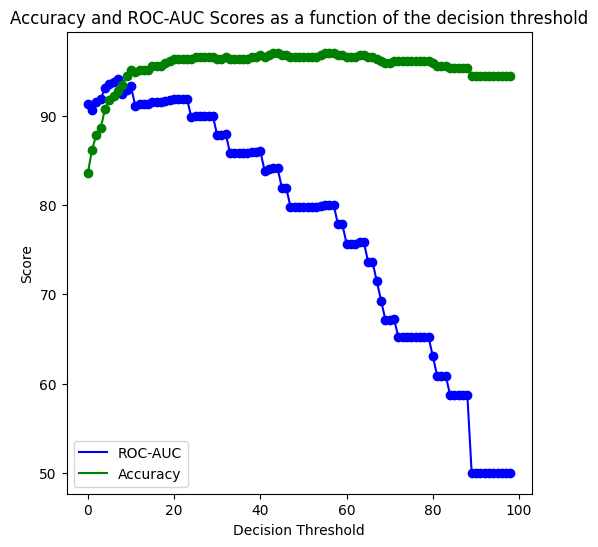

In [11]:
cross_val_ypred = cross_val_predict(RandomForestClassifier(random_state = 1, oob_score = True, verbose = False, n_jobs=-1, max_depth = 3, n_estimators = 250), X_train, y_train, cv = 5, method = 'predict_proba')

def plot_accuracy_recall_vs_threshold(y_proba, y_true):
    ra_iter = []
    accuracy_iter = []
    threshold_val = 100
    threshold_hyperparam_vals = np.arange(0.01, 1, 0.01)
    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = y_proba[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        accuracy = accuracy_score(y_true, predicted_class)*100
        rocauc = roc_auc_score(y_true, predicted_class)*100
        accuracy_iter.append(accuracy)
        ra_iter.append(rocauc)
        if (accuracy > rocauc) & (threshold_prob < threshold_val):
            threshold_val = threshold_prob
            print(threshold_val)
    
    plt.figure(figsize=(6, 6))
    plt.title("Accuracy and ROC-AUC Scores as a function of the decision threshold")
    plt.plot(ra_iter, "b-", label= "ROC-AUC")
    plt.plot(accuracy_iter, "g-", label="Accuracy")
    plt.plot(ra_iter, "o", color = 'blue')
    plt.plot(accuracy_iter, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()

plot_accuracy_recall_vs_threshold(cross_val_ypred, y_train)

In [12]:
model = RandomForestClassifier(
    random_state = 1, 
    oob_score = True, 
    verbose = False, 
    n_jobs=-1, 
    max_depth = 3, 
    n_estimators = 250).fit(X_train, y_train)

In [13]:
y_pred = (model.predict_proba(X_test)[:,1] > .11).astype(int)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("ROC_AUC:", roc_auc)

Accuracy: 0.900709219858156
Recall: 0.6521739130434783
Precision: 0.30612244897959184
ROC_AUC: 0.7835869565217392


### Bagged trees 
*By Shray Vaidya*

In [14]:
#Finding optimal hyperparameters
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'base_estimator': [DecisionTreeClassifier(random_state = 1)],
          'n_estimators': [250,300,350,400,450,500,550],
          'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}


cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['roc_auc', 'accuracy'], refit='roc_auc')
res = bagging_classifier_grid.fit(X_train, y_train)

print("Best Recall Score: %f" % (res.cv_results_['mean_test_accuracy'][res.best_index_]))
print("Best ROC-AUC Score: %f" % (res.cv_results_['mean_test_roc_auc'][res.best_index_]))
print("Best Hyperparameters: ", res.best_params_)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
Best Recall Score: 0.978313
Best ROC-AUC Score: 0.994053
Best Hyperparameters:  {'base_estimator': DecisionTreeClassifier(random_state=1), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 250}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [15]:
#Best model
model = bagging_classifier_grid.best_estimator_
#Feature importances
# Data structure to store sum of feature importance and number of times it showed up
total = [0] * 26
# Loop through every tree in bagging regressor
for i, temp_model in enumerate(model.estimators_): # model is bagging regressor
    feature = model.estimators_features_[i] # Get the predictors the specific tree uses
    for j, predictor in enumerate(feature): # loop the predictors
        total[predictor] += temp_model.feature_importances_[j] # Add the specific feature importance to the array
imps = np.array(total)/len(model.estimators_) #convert to numpy array for easy elementwise division

pd.Series(imps, index = X_train.columns).sort_values(ascending = False)

PTS     0.532374
eFG%    0.144383
FG      0.081132
TOV     0.057140
3P      0.020639
AST     0.019018
DRB     0.018758
TRB     0.017966
FGA     0.014549
3PA     0.013680
FT%     0.013031
FT      0.008626
MP      0.008054
2P%     0.007537
G       0.005626
2P      0.005586
2PA     0.004580
PF      0.004360
Age     0.004100
GS      0.003779
3P%     0.003158
FG%     0.003131
ORB     0.002903
FTA     0.002264
STL     0.002167
BLK     0.001461
dtype: float64

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.012


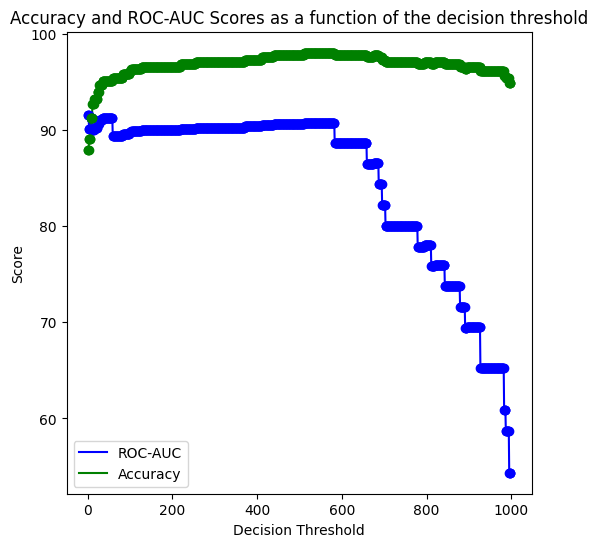

In [16]:
cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')

def plot_accuracy_recall_vs_threshold(y_proba, y_true):
    ra_iter = []
    accuracy_iter = []
    threshold_val = 100
    threshold_hyperparam_vals = np.arange(0.001, 1, 0.001)
    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = y_proba[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        accuracy = accuracy_score(y_true, predicted_class)*100
        rocauc = roc_auc_score(y_true, predicted_class)*100
        accuracy_iter.append(accuracy)
        ra_iter.append(rocauc)
        if (accuracy > rocauc) & (threshold_prob < threshold_val):
            threshold_val = threshold_prob
            print(threshold_val)
    
    plt.figure(figsize=(6, 6))
    plt.title("Accuracy and ROC-AUC Scores as a function of the decision threshold")
    plt.plot(ra_iter, "b-", label= "ROC-AUC")
    plt.plot(accuracy_iter, "g-", label="Accuracy")
    plt.plot(ra_iter, "o", color = 'blue')
    plt.plot(accuracy_iter, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()

plot_accuracy_recall_vs_threshold(cross_val_ypred, y_train)

Accuracy:  87.70685579196218
ROC-AUC:  0.8367391304347825
Precision:  0.26229508196721313
Recall:  0.6956521739130435


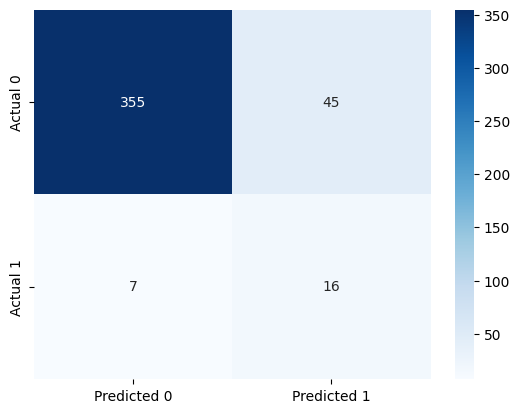

In [17]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.012

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.